In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from astropy.table import Table

# File reading
import linecache

# Matplotlib
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
#%matplotlib notebook
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{bm} \usepackage{physics}']
%config InlineBackend.figure_format = 'retina' # For high quality figures
%load_ext autoreload
%autoreload 2

## Load the magnitudes and colors

In [2]:
data_folder = "data-2019-09-23-nickel-joey-anne"
n_iters = 1

In [3]:
merged_asof_v_mags     = np.load(os.path.join(data_folder, 
                                              'color_and_mag_results/merged_asof_v_mags_iter_{}.npy'.format(n_iters)))
merged_asof_b_mags     = np.load(os.path.join(data_folder, 
                                              'color_and_mag_results/merged_asof_b_mags_iter_{}.npy'.format(n_iters)))
merged_asof_b_minus_v  = np.load(os.path.join(data_folder, 
                                              'color_and_mag_results/merged_asof_b_minus_v_iter_{}.npy'.format(n_iters)))
merged_asof_abs_v_mags = np.load(os.path.join(data_folder, 
                                              'color_and_mag_results/merged_asof_abs_v_mags_iter_{}.npy'.format(n_iters)))

## Make a color magnitude diagram and a HR-Diagram

In [4]:
def plot(x, y, xlabel, ylabel, n_text_coords, xlim=None, fname=None):
    
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(x, y, '.', alpha=0.3)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(labelsize=14)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    
    ax.set_title('NGC 6819', size=14)
    
    x_text, y_text = n_text_coords
    ax.text(x_text, y_text, 'N = {}'.format(x.shape[0]), fontsize=12)
    
    ax.set_ylim((0,6))
    plt.gca().invert_yaxis()
    fig.tight_layout()
    
    if fname is not None:
        fname = os.path.join('figures', fname)
        fig.savefig(os.path.join(data_folder, fname))
    
    plt.show()

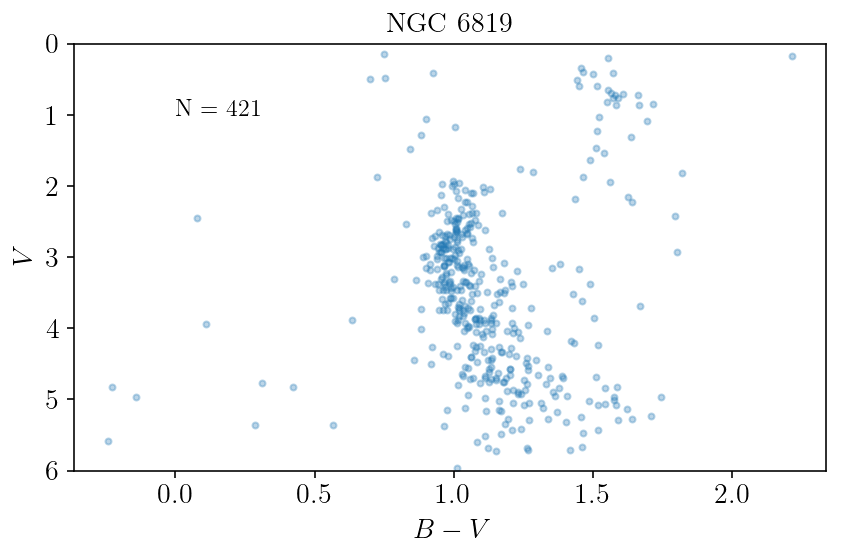

In [5]:
plot(merged_asof_b_minus_v, merged_asof_abs_v_mags, r'$B - V$', r'$V$', (0., 1.))

## Load the isochrones table as a DataFrame

From: http://stev.oapd.inaf.it/cgi-bin/cmd_3.3

Table filenames: 
    - iso_table_yearStart_yearEnd_step_Gyr.txt
    - isochrones/iso_table_1_10_1_Gyr.txt
    - isochrones/iso_table_1_4_0.5_Gyr.txt
    - isochrones/iso_table_1_4_1_Gyr.txt
    - isochrones/iso_table_0.1_100_1_Gyr.txt

In [114]:
isochrone_fname = os.path.join(data_folder, 'isochrones/iso_table_1_4_1_Gyr.txt')
column_names    = linecache.getline(isochrone_fname, 12).split()[1:]

iso_df = pd.read_csv(isochrone_fname, skiprows=12, sep=' ', header=None, skipinitialspace=True, comment='#')
iso_df.columns = column_names

### Split into several dfs based on logAge

In [115]:
logAge_list = np.unique(iso_df['logAge'])
iso_df_age_list = []

for logAge in logAge_list:
    iso_df_age_list.append(iso_df.loc[iso_df.logAge == logAge])

## Add B - V as a column to each of the isochrone dfs

In [116]:
for df in iso_df_age_list:
    b_minus_v = df.loc[:, 'Bmag'].values - df.loc[:, 'Vmag'].values
    df['Bmag-Vmag'] = b_minus_v
    
# Ignore this annoying warning from Pandas for now

/Users/josephmurphy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Plot the isochrones over the real color magnitude diagram to infer cluster age

In [119]:
def plot_with_isochrones(x, y, logAge_list, isochrone_list, xlim=None, fname=None):
    
    fig, ax = plt.subplots(figsize=(6,4))
    
    # Plot the isochrones
    n_iso = len(isochrone_list)
    iso_cmap = plt.get_cmap('viridis', n_iso)
    for i in range(len(isochrone_list)):
        iso_df = isochrone_list[i]
        shift_x = 0.6
        shift_y = 0.
        # [:-10] slicing gets rid of some weird data points at the end of the values array
        ax.plot(iso_df.loc[:, 'Bmag-Vmag'].values[:-10] + shift_x, iso_df.loc[:, 'Vmag'].values[:-10] + shift_y, '-', 
                color=iso_cmap(i))
        
    ax.plot(-100, 0, 'k-', label='Isocrhone') # Dummy data point for the isochrone label
    
    # Isochrone colobar
    age_list = 10**np.array(logAge_list) * 1e-9 # Ages in Gyr
    norm = mpl.colors.Normalize(vmin=min(age_list), vmax=max(age_list))
    sm   = plt.cm.ScalarMappable(cmap=iso_cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=age_list)
    
    # Works only if using isochrones/iso_table_1_4_1_Gyr.txt
    # Puts tick labels at base of new color in colorbar.
    offset = -0.25 * np.arange(0, len(age_list))
    tick_locs = np.arange(1, len(age_list)+1) + offset
    cbar.set_ticks(tick_locs)
    
    cbar.ax.yaxis.set_ticks([], minor=True) # Weird matplotlib bug fix needs this line
    cbar.ax.set_yticklabels(['{:.2f}'.format(age) for age in age_list], fontsize=12)
    cbar.ax.set_ylabel('Age (Gyr)', rotation=270, labelpad=18, fontsize=14)
    
    # Overplot the cluster data
    ax.plot(x, y, '.', alpha=0.3, label='Data, N = {}'.format(x.shape[0]))
    
    # Figure housekeeping
    ax.set_xlabel(r"$B - V$", fontsize=14)
    ax.set_ylabel(r"$M_V$", fontsize=14)
    ax.tick_params(labelsize=14)
    
    ax.set_ylim(top=9., bottom=-2.)
    ax.set_xlim(left=-0.25, right=2.5)
    if xlim is not None:
        ax.set_xlim(xlim)
    
    ax.set_title('NGC 6819', size=14)
    
    plt.gca().invert_yaxis()
    fig.tight_layout()
    
    ax.legend(loc='lower left', fancybox=True, fontsize=12)
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(MultipleLocator(1.))
    ax.grid(which='both', alpha=0.25)
    
    # Save figure if filename specified
    if fname is not None:
        fname = os.path.join('figures', fname)
        fig.savefig(os.path.join(data_folder, fname))
    
    # Display
    plt.show()

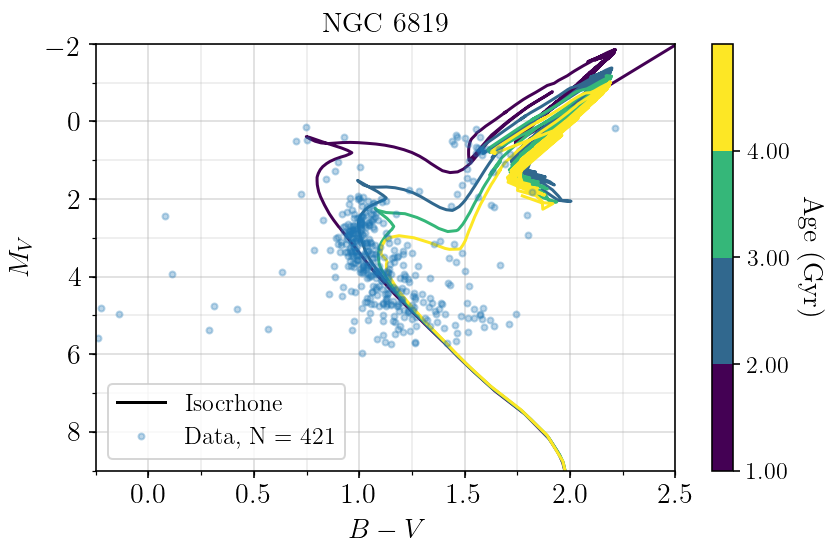

In [120]:
plot_with_isochrones(merged_asof_b_minus_v, 
                     merged_asof_abs_v_mags, 
                     logAge_list, 
                     iso_df_age_list, 
                     fname='hr_diagram_merge_asof_iter_{}_iso_1_4_1_thin_iso_lines_viridis_fixed_ticks.pdf'.format(n_iters))

